In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt


In [ ]:
DATA_PATH = "customer_pd_dataset.csv"
df = pd.read_csv(DATA_PATH)

# If your CSV doesn't contain default_flag_v3 yet, create it here (v3 rule):
if "default_flag_v3" not in df.columns:
    df["default_flag_v3"] = np.where(
        (df["return_rate"] >= 0.40) |
        ((df["return_rate"] >= 0.20) & (df["total_profit"] < 0) & (df["avg_discount"] >= 0.30)),
        1, 0
    )

print("Bad rate:", df["default_flag_v3"].mean())
df.head()


Bad rate: 0.053344817685902955


,total_orders,total_sales,total_profit,avg_discount,avg_shipping_delay,return_rate,customer_tenure_days,orders_per_year,default_flag,default_flag_v3
0,2,544.656,-153.0540,0.416667,3.333333,0.0,918,0.795207,0,0
1,1,2713.410,27.0900,0.000000,5.000000,0.0,0,1.000000,0,0
2,4,2955.798,514.6680,0.030769,2.692308,0.0,319,4.576803,0,0
3,2,4780.552,-650.5971,0.133333,5.000000,0.0,483,1.511387,0,0
4,2,753.508,274.4320,0.066667,4.333333,0.0,553,1.320072,0,0


In [ ]:
TARGET = "default_flag_v3"

leakage_features = [
    "return_rate",
    "avg_discount",
    "total_profit"
]

numeric_cols = [
    c for c in df.columns
    if c != TARGET
    and pd.api.types.is_numeric_dtype(df[c])
    and c not in leakage_features
]

X = df[numeric_cols].copy()
y = df[TARGET].astype(int).copy()

print("Features used (leakage-safe):", numeric_cols)



Features used (leakage-safe): ['total_orders', 'total_sales', 'avg_shipping_delay', 'customer_tenure_days', 'orders_per_year', 'default_flag']


In [ ]:
time_col_candidates = [c for c in df.columns if "date" in c.lower() or "month" in c.lower()]

if len(time_col_candidates) > 0:
    time_col = time_col_candidates[0]
    print("Using time column:", time_col)

    tmp = df.copy()
    tmp[time_col] = pd.to_datetime(tmp[time_col], errors="coerce")
    tmp = tmp.sort_values(time_col)

    split_idx = int(len(tmp) * 0.80)
    train_idx = tmp.index[:split_idx]
    test_idx  = tmp.index[split_idx:]

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]
else:
    print("No time column found → using stratified random split (document as limitation).")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

print("Train bad rate:", y_train.mean())
print("Test bad rate :", y_test.mean())


No time column found → using stratified random split (document as limitation).
Train bad rate: 0.053330462245190925
Test bad rate : 0.053402239448751075


In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_cols)],
    remainder="drop"
)

model = LogisticRegression(
    penalty="l2",
    C=1.0,               # regularization strength (tune later)
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

clf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_orders',
                                                   'total_sales',
                                                   'avg_shipping_delay',
                                                   'customer_tenure_days',
                                                   'orders_per_year',
                                                   'default_flag'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [ ]:
clf.fit(X_train, y_train)

pd_train = clf.predict_proba(X_train)[:, 1]
pd_test  = clf.predict_proba(X_test)[:, 1]

print("Train PD range:", (pd_train.min(), pd_train.max()))
print("Test  PD range:", (pd_test.min(), pd_test.max()))


Train PD range: (np.float64(0.3354370961935121), np.float64(0.9999413592937659))
Test  PD range: (np.float64(0.3355693075705295), np.float64(0.9988510106803021))


In [ ]:
auc = roc_auc_score(y_test, pd_test)
prauc = average_precision_score(y_test, pd_test)

print(f"ROC-AUC: {auc:.4f}")
print(f"PR-AUC : {prauc:.4f}")


ROC-AUC: 0.6755
PR-AUC : 0.3352


KS: 0.3220
KS threshold: 0.4456


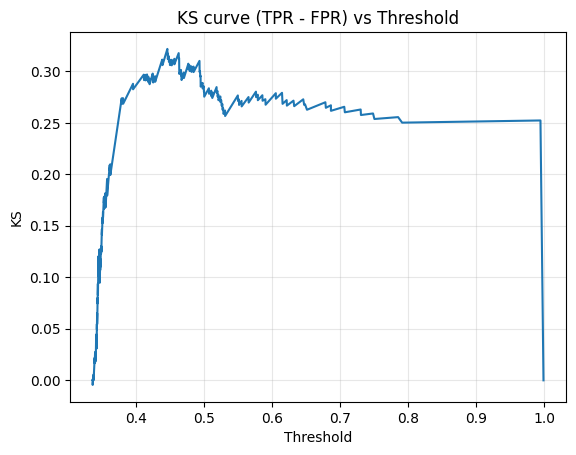

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pd_test)
ks = np.max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"KS: {ks:.4f}")
print(f"KS threshold: {ks_threshold:.4f}")

plt.figure()
plt.plot(thresholds, tpr - fpr)
plt.title("KS curve (TPR - FPR) vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("KS")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
chosen_threshold = ks_threshold

y_pred = (pd_test >= chosen_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix at KS threshold:")
print(cm)


Confusion matrix at KS threshold:
[[2515  782]
 [  82  104]]


In [ ]:
eval_df = pd.DataFrame({"pd": pd_test, "y": y_test.values})
eval_df["decile"] = pd.qcut(eval_df["pd"], 10, duplicates="drop")

cal = eval_df.groupby("decile").agg(
    n=("y","size"),
    avg_pd=("pd","mean"),
    observed_dr=("y","mean")
).reset_index()

cal


/tmp/ipython-input-3296856260.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = eval_df.groupby("decile").agg(


,decile,n,avg_pd,observed_dr
0,"(0.335, 0.341]",349,0.339242,0.034384
1,"(0.341, 0.343]",348,0.342009,0.034483
2,"(0.343, 0.345]",348,0.343903,0.037356
3,"(0.345, 0.348]",348,0.346451,0.043103
4,"(0.348, 0.355]",349,0.351057,0.031519
5,"(0.355, 0.368]",348,0.359977,0.020115
6,"(0.368, 0.423]",348,0.391156,0.022989
7,"(0.423, 0.476]",348,0.448624,0.048851
8,"(0.476, 0.552]",348,0.510607,0.071839
9,"(0.552, 0.999]",349,0.675453,0.189112


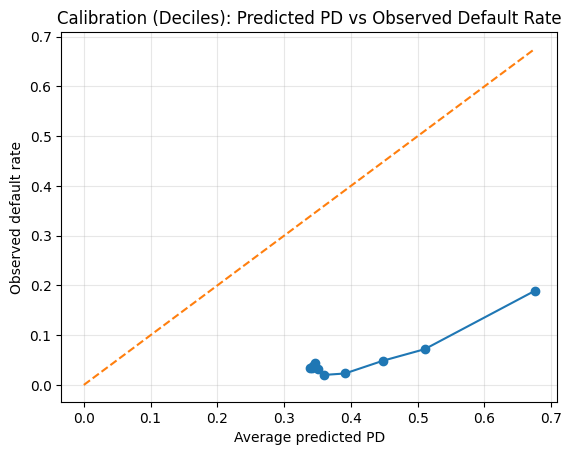

In [ ]:
plt.figure()
plt.plot(cal["avg_pd"], cal["observed_dr"], marker="o")
plt.plot([0, cal["avg_pd"].max()], [0, cal["avg_pd"].max()], linestyle="--")
plt.title("Calibration (Deciles): Predicted PD vs Observed Default Rate")
plt.xlabel("Average predicted PD")
plt.ylabel("Observed default rate")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Get feature names and coefficients
feature_names = numeric_cols
coefs = clf.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
}).sort_values("coef", ascending=False)

coef_df


,feature,coef
5,default_flag,0.731750
0,total_orders,0.181051
3,customer_tenure_days,0.140466
1,total_sales,0.121642
4,orders_per_year,0.101293
2,avg_shipping_delay,0.008941
